In [1]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2024-04-25 00:32:37.851048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 00:32:37.851175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 00:32:38.030254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv


In [2]:
def norm(var):
    scaler = StandardScaler()
    return scaler.fit_transform(var)

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.show()

# Data

In [3]:
df = pd.read_csv("/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv")
display(df.sample(5))
corr_mat = df.corr().round(3)
corr_mat.style.background_gradient(cmap='coolwarm')

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
509,0.71,710.5,269.5,220.50,3.5,3,0.25,5,12.19,14.71
492,0.82,612.5,318.5,147.00,7.0,2,0.25,5,25.70,26.53
568,0.64,784.0,343.0,220.50,3.5,2,0.40,1,19.52,22.72
625,0.98,514.5,294.0,110.25,7.0,3,0.40,3,32.69,33.24
538,0.86,588.0,294.0,147.00,7.0,4,0.40,1,32.09,31.70


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
X1,1.000000,-0.992000,-0.204000,-0.869000,0.828000,0.000000,-0.000000,-0.000000,0.622000,0.634000
X2,-0.992000,1.000000,0.196000,0.881000,-0.858000,-0.000000,0.000000,0.000000,-0.658000,-0.673000
X3,-0.204000,0.196000,1.000000,-0.292000,0.281000,-0.000000,-0.000000,0.000000,0.456000,0.427000
X4,-0.869000,0.881000,-0.292000,1.000000,-0.973000,-0.000000,-0.000000,-0.000000,-0.862000,-0.863000
X5,0.828000,-0.858000,0.281000,-0.973000,1.000000,0.000000,0.000000,-0.000000,0.889000,0.896000
X6,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.003000,0.014000
X7,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000,0.213000,0.270000,0.208000
X8,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.213000,1.000000,0.087000,0.051000
Y1,0.622000,-0.658000,0.456000,-0.862000,0.889000,-0.003000,0.270000,0.087000,1.000000,0.976000
Y2,0.634000,-0.673000,0.427000,-0.863000,0.896000,0.014000,0.208000,0.051000,0.976000,1.000000


Retain variables that have strong correlations with the output variables (Y1 and Y2) while minimizing multicollinearity among the input variables (X1 to X8).

Considering:

- High Correlation with Outputs (Y1 and Y2)
- Multicollinearity: Check for high correlations among the input variables (X1 to X8)

Correlation to output variables:

In [4]:
feature_selector = lambda col: ~corr_mat.columns.isin([col,"Y1","Y2"])
sort_corr = lambda col: corr_mat.loc[col,feature_selector(col)].sort_values(ascending=False)
print("Most correlated features to Y1:")
display(sort_corr("Y1"))
print("\nMost correlated features to Y2:")
display(sort_corr("Y2"))

Most correlated features to Y1:


X5    0.889
X1    0.622
X3    0.456
X7    0.270
X8    0.087
X6   -0.003
X2   -0.658
X4   -0.862
Name: Y1, dtype: float64


Most correlated features to Y2:


X5    0.896
X1    0.634
X3    0.427
X7    0.208
X8    0.051
X6    0.014
X2   -0.673
X4   -0.863
Name: Y2, dtype: float64

Multicolinearity between feature variables:

In [5]:
corr_mat_feat = corr_mat.loc[feature_selector,feature_selector]
cumm = []
for i,row in corr_mat_feat.iterrows():
    print(f"for {i}:")
    cors = sort_corr(i)
    non_repeated = [r not in cumm for r in cors.index]
    print(cors.loc[non_repeated],"\n")
    cumm.append(i)


for X1:
X5    0.828
X6    0.000
X7   -0.000
X8   -0.000
X3   -0.204
X4   -0.869
X2   -0.992
Name: X1, dtype: float64 

for X2:
X4    0.881
X3    0.196
X6   -0.000
X7    0.000
X8    0.000
X5   -0.858
Name: X2, dtype: float64 

for X3:
X5    0.281
X6   -0.000
X7   -0.000
X8    0.000
X4   -0.292
Name: X3, dtype: float64 

for X4:
X6   -0.000
X7   -0.000
X8   -0.000
X5   -0.973
Name: X4, dtype: float64 

for X5:
X6    0.0
X7    0.0
X8   -0.0
Name: X5, dtype: float64 

for X6:
X7   -0.0
X8   -0.0
Name: X6, dtype: float64 

for X7:
X8    0.213
Name: X7, dtype: float64 

for X8:
Series([], Name: X8, dtype: float64) 



Considering the correlation to the output variables, and between features, the variables chosen are: x5,x3,x7


- X1 ignored due to its high correlation with X5, of  0.828 (X5 had higher correlation to both output variables: 0.889 with Y1, and 0.896 with Y2)
- X2 ignored due to its high correlation with X5, of -0.858
- X4 ignored due to its high correlation with X5, of -0.973
- X8 ignored due to its low correlation to both output variables (0.087 with Y1, and 0.051 with Y2)
- X6 ignored due to its low correlation to both output variables (-0.003 with Y1, and 0.014 with Y2)


In [6]:
keeped_vars = ["X5","X3","X7","Y1","Y2"]
df = df.loc[:,keeped_vars]
display(df.sample(5))
corr_mat = df.corr().round(3)
corr_mat.style.background_gradient(cmap='coolwarm')

,X5,X3,X7,Y1,Y2
34,3.5,294.0,0.0,6.77,11.73
235,3.5,343.0,0.1,15.16,19.48
171,3.5,245.0,0.1,10.38,13.49
584,7.0,294.0,0.4,32.48,35.48
123,3.5,245.0,0.1,10.45,13.79


,X5,X3,X7,Y1,Y2
X5,1.000000,0.281000,0.000000,0.889000,0.896000
X3,0.281000,1.000000,-0.000000,0.456000,0.427000
X7,0.000000,-0.000000,1.000000,0.270000,0.208000
Y1,0.889000,0.456000,0.270000,1.000000,0.976000
Y2,0.896000,0.427000,0.208000,0.976000,1.000000


In [7]:
features = keeped_vars[:3]
out_vars = keeped_vars[3:]
Xs = df.loc[:,features].values
Xs_norm = norm(Xs)

Y1 = df.loc[:,"Y1"].values
Y1_norm = norm(Y1.reshape(-1,1))
Y2 = df.loc[:,"Y2"].values
Y2_norm = norm(Y2.reshape(-1,1))

In [8]:
result = train_test_split(Xs_norm,Y1_norm,Y2_norm, test_size=0.2, shuffle=True)
Xs_train, Xs_test,Y1_train,Y1_test,Y2_train, Y2_test = result

# Model

In [9]:
def model(input_shape):

    input_img = Input(shape=(input_shape))

    X = Dense(128, activation="relu")(input_img)
    X = Dense(128, activation="relu")(X)
    
    Y1 = Dense(units=1,name="y1_output")(X)
    
    X2 = Dense(64, activation="relu")(X)
    Y2 = Dense(units=1,name="y2_output")(X2)

    model = Model(inputs=input_img, outputs=[Y1,Y2])

    return model

num_features = len(features)
my_model = model((num_features,))

train

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_output (Dense)   │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_output (Dense)   │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,474 (99.51 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 0 (0.00 B)

None

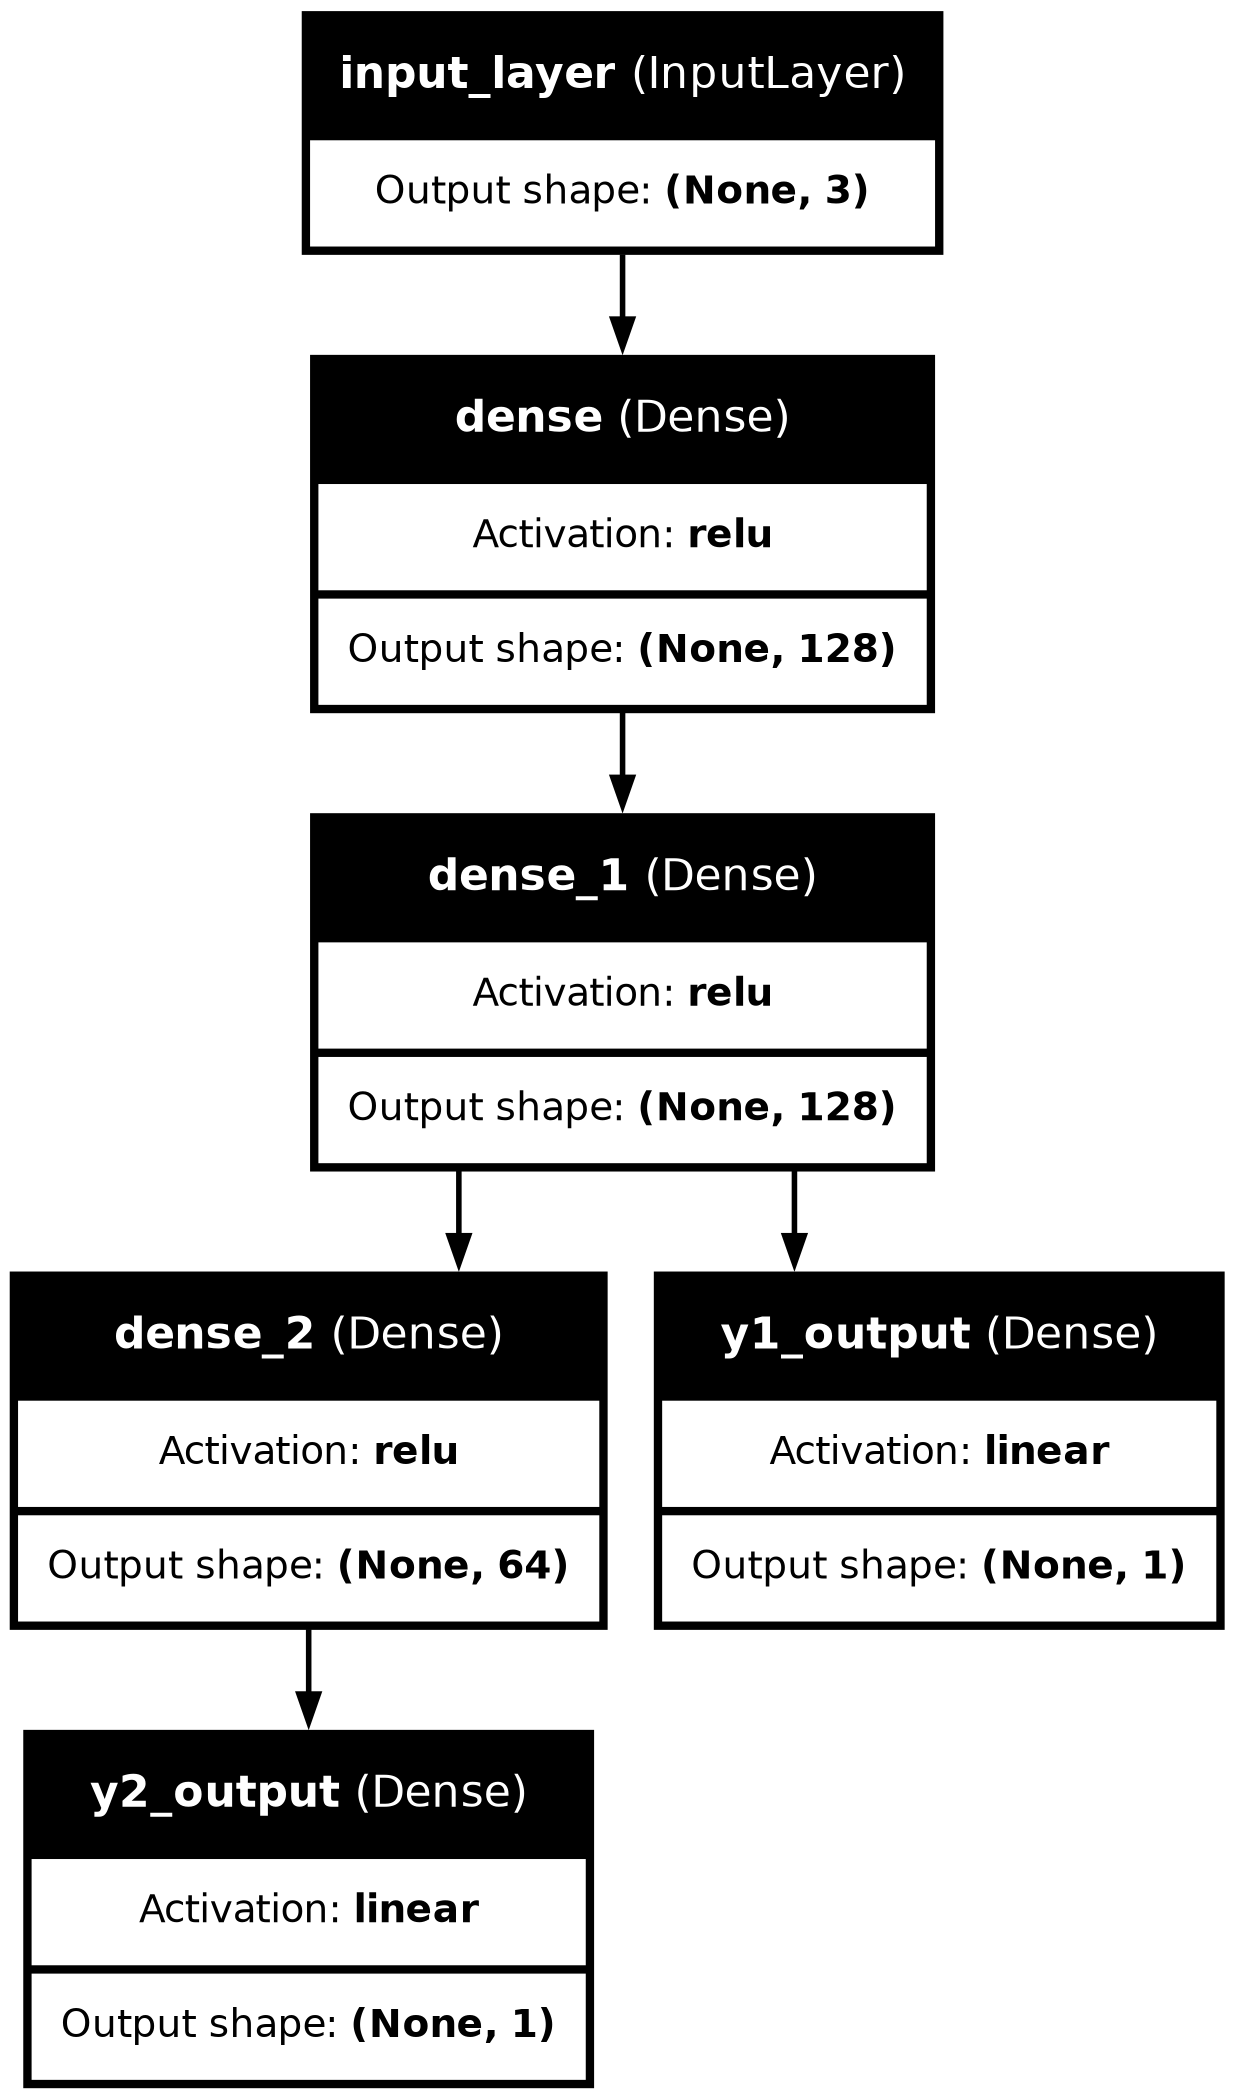

In [10]:
optimizer = tf.keras.optimizers.SGD(0.001)
my_model.compile(
    optimizer=optimizer, 
    loss={'y1_output': 'mse', 'y2_output': 'mse'}, 
    metrics={'y1_output': "mse", 'y2_output': "mse"}
)
display(my_model.summary())
tf.keras.utils.plot_model(
    my_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

In [11]:
model_path = "saved_models/my_model.keras"
checkpoint_path = "checkpoints/my_model_checkpoint/my_model.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor='mse',save_weights_only=True,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='mse', patience=2, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='mse',mode='min', patience=5, restore_best_weights=True,verbose=1)

# if os.path.exists(checkpoint_path):
#     latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
#     my_model.load_weights(latest_cp)
history = my_model.fit(
        Xs_train,(Y1_train,Y2_train),
        epochs=500,
        batch_size=64,
        callbacks=[reduce_lr, early_stopping,cp_callback],validation_data=(Xs_test,(Y1_test,Y2_test))
    )
my_model.save('my_model.keras')

Epoch 1/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - loss: 1.7821 - y1_output_mse: 0.8334 - y2_output_mse: 0.9487
Epoch 1: saving model to checkpoints/my_model_checkpoint/my_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.6382 - y1_output_mse: 0.7797 - y2_output_mse: 0.8588 - val_loss: 1.7813 - val_y1_output_mse: 0.8340 - val_y2_output_mse: 1.0212 - learning_rate: 0.0010
Epoch 2/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4214 - y1_output_mse: 0.6899 - y2_output_mse: 0.7315
Epoch 2: saving model to checkpoints/my_model_checkpoint/my_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5942 - y1_output_mse: 0.7460 - y2_output_mse: 0.8493 - val_loss: 1.7184 - val_y1_output_mse: 0.8025 - val_y2_output_mse: 0.9879 - learning_rate: 0.0010
Epoch 3/500


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `mse` which is not available. Available metrics are: loss,y1_output_mse,y2_output_mse,val_loss,val_y1_output_mse,val_y2_output_mse,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `mse` which is not available. Available metrics are: loss,y1_output_mse,y2_output_mse,val_loss,val_y1_output_mse,val_y2_output_mse,learning_rate
  current = self.get_monitor_value(logs)


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5737 - y1_output_mse: 0.7629 - y2_output_mse: 0.8108
Epoch 3: saving model to checkpoints/my_model_checkpoint/my_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5329 - y1_output_mse: 0.7223 - y2_output_mse: 0.8118 - val_loss: 1.6588 - val_y1_output_mse: 0.7722 - val_y2_output_mse: 0.9565 - learning_rate: 0.0010
Epoch 4/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.5501 - y1_output_mse: 0.7204 - y2_output_mse: 0.8297
Epoch 4: saving model to checkpoints/my_model_checkpoint/my_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4935 - y1_output_mse: 0.6933 - y2_output_mse: 0.7990 - val_loss: 1.6007 - val_y1_output_mse: 0.7428 - val_y2_output_mse: 0.9259 - learning_rate: 0.0010
Epoch 5/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4643 - y1_output_mse: 0.7013 - y2_output_mse: 0.7630
Epoch 5: saving model to checkpoints/my_model_checkpoint/my_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

# Model Evaluation

In [12]:
my_model.evaluate(x=Xs_test, y=(Y1_test,Y2_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 - y1_output_mse: 0.0519 - y2_output_mse: 0.0859 


[0.12829801440238953, 0.04756604880094528, 0.0827830359339714]

In [13]:
history.history["val_y1_output_mse"][:10]

[0.8339776396751404,
 0.8024727702140808,
 0.772177517414093,
 0.7428256273269653,
 0.7145380973815918,
 0.6872771978378296,
 0.6608014106750488,
 0.6352371573448181,
 0.6104782819747925,
 0.5867095589637756]

In [14]:
history.history["y1_output_mse"][:10]

[0.7751458883285522,
 0.7455316781997681,
 0.7171533703804016,
 0.6895562410354614,
 0.6629725694656372,
 0.6375157237052917,
 0.6128676533699036,
 0.5888628959655762,
 0.5657230615615845,
 0.5433692932128906]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


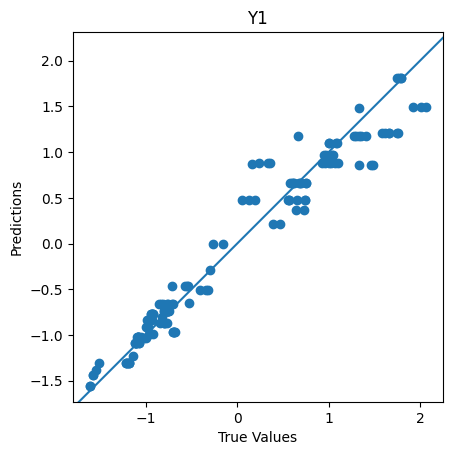

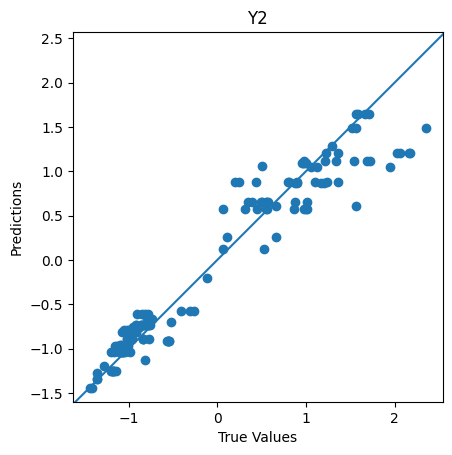

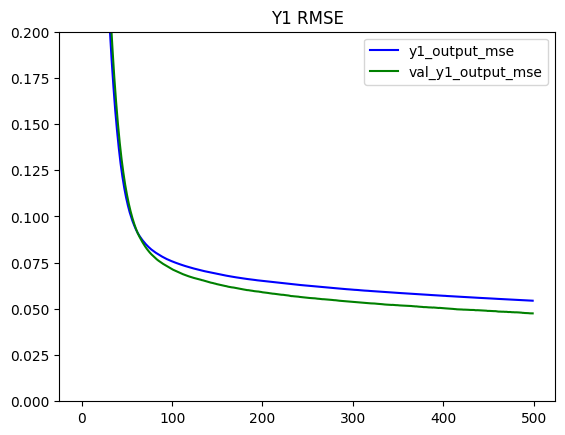

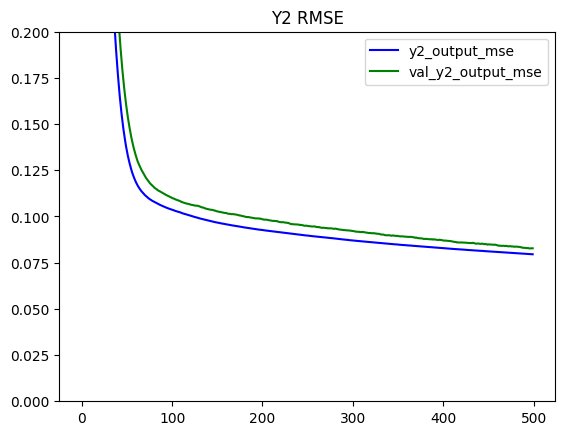

In [15]:
Y_pred = my_model.predict(Xs_test)
plot_diff(Y1_test, Y_pred[0], title='Y1')
plot_diff(Y2_test, Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_mse', title='Y1 RMSE', ylim=0.2)
plot_metrics(metric_name='y2_output_mse', title='Y2 RMSE', ylim=0.2)